In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from nltk.corpus import stopwords
import string
import re
from nltk.stem.wordnet import WordNetLemmatizer
import unicodedata

from random import randint

import gensim.downloader as api
from gensim.corpora import Dictionary
from gensim import corpora

from collections import namedtuple
from operator import itemgetter
from gensim.utils import simple_preprocess

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors

from sklearn.model_selection import train_test_split

import shap
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

import xgboost 
import transformers
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics.pairwise import cosine_similarity

from time import asctime

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.model_selection import GridSearchCV

from wordcloud import WordCloud, STOPWORDS

from pandarallel import pandarallel

In [2]:
pandarallel.initialize(nb_workers=3, progress_bar=True)

INFO: Pandarallel will run on 3 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
df = pd.read_csv("../data/master-thesis-dataset-large_specChars_rm_and_wo_foods_or_keywords_wbigrams_label.csv")
df['processed_text_tokens'] = df['processed_text_tokens'].apply(eval)
df = df[df.Text_Term_Count>0]

questions_df = pd.read_csv("../data/questions.csv")
questions = questions_df.question.values.tolist()
questions_df['processed_question_tokens'] = questions_df.processed_question_tokens.apply(eval)

In [4]:
df.Price.describe()

count    255797.000000
mean         83.666687
std         119.780297
min           4.500000
25%          21.582500
50%          39.990000
75%          90.000000
max         999.990000
Name: Price, dtype: float64

In [5]:
df.processed_text_str.isnull().sum()

0

In [6]:
df = df[df.Text_Term_Count>0]

In [8]:
print('nulls of essential column post-filter', df.processed_text_str.isnull().sum())

nulls of essential column post-filter 0


In [9]:
df.head(2)

,Full_Vintage_Name,Winery_Name,Vintage_Year,Short_Wine_Name,Type_ID,Region,Country,Price,Currency,Wine_ID,...,polarity,subjectivity,Pos_or_Neg,Weighted_Rating,text,processed_text_str,processed_text_tokens,Text_Term_Count,Text_Char_Count,Label2
0,Champalou Vouvray 2021,Champalou,2021,Vouvray,2.0,Vouvray,France,23.95,USD,1172337.0,...,0.080000,0.520000,happy,2.252295,"🧐 light yellow\n🤥 citrus\n😛 honey, pear, citr...",light_yellow citrus honey pear_citrus apple un...,"[light_yellow, citrus, honey, pear_citrus, app...",14,101,Chenin_Blanc
1,Domaine Anne Gros Clos-Vougeot Grand Cru Le Gr...,Domaine_Anne_Gros,2017.0,Clos-Vougeot Grand Cru Le Grand Maupertui,1.0,Clos Vougeot Grand Cru,France,290.00,USD,1137843.0,...,0.421667,0.762738,happy,2.750736,🧐 When the top quality grape meets the experti...,top_quality grape meet expertise winemaker get...,"[top_quality, grape, meet, expertise, winemake...",42,377,Burgundy_Red


In [10]:
df.groupby('Label').count()[['Full_Vintage_Name']].sort_values('Full_Vintage_Name', ascending=False).head() # max count per label is 20,000, which should be manageable

,Full_Vintage_Name
Label,
Spain Tempranillo,20206
Italy Sangiovese,17715
United States Pinot Noir,17350
United States Cabernet Sauvignon,16249
Italy Nebbiolo,14559


In [13]:
questions_df.head()

,question,processed_question_str,processed_question_tokens
0,I want to split a bottle of wine with my frien...,want split bottle friend birthday likely eat s...,"[want, split, bottle, friend, birthday, likely..."
1,Tonight I will be eating pasta at the Italian ...,tonight eat pasta italian_restaurant dinner nt...,"[tonight, eat, pasta, italian, restaurant, din..."
2,I like Cabernets from Napa Valley,like cabernet napa_valley,"[like, cabernet, napa, valley]"
3,I'm looking to try something different for my ...,look try_something_different dinner tonight wh...,"[look, try, something, different, dinner, toni..."
4,I don't know what I want.,nt know want,"[nt, know, want]"


# Reduce Dimensionality Based on Data Attributes

In [11]:
asctime()

'Sun Apr 30 17:44:16 2023'

In [12]:
df2 = pd.DataFrame()

for label in df.Label.unique():
    text = ''.join(df[df['Label']==label]['processed_text_str'])
    inner_df2 = pd.DataFrame([text], columns=['processed_text_str'])
    inner_df2['label'] = label
    df2 = pd.concat([df2, inner_df2])

In [13]:
df2.shape

(93, 2)

In [14]:
df2.reset_index(inplace=True, drop=True)

In [15]:
df2.head()

,processed_text_str,label
0,light_yellow citrus honey pear_citrus apple un...,France Chenin Blanc
1,top_quality grape meet expertise winemaker get...,France Pinot Noir
2,young good 42 potential become outstanding tan...,Italy Nebbiolo
3,limited experience excellent representation ch...,Italy Sangiovese
4,beautiful complex nicely_balance sophisticated...,France Chardonnay


In [16]:
df2['processed_text_tokens'] = df2.processed_text_str.apply(lambda xyz: xyz.split())

In [17]:
len(df2.label.unique())

93

In [18]:
len(df2.processed_text_str.unique())

93

In [19]:
# use with tfidf later
#df2.to_csv("../data/reduced_dimension_93Labels_dataset.csv", index=False)

In [20]:
asctime()

'Sun Apr 30 17:44:48 2023'

# Prepare for model

In [21]:
asctime()

'Sun Apr 30 17:44:55 2023'

In [22]:
more_stop_words = []
for grape in df2.label.unique():
    more_stop_words_label = df2[df2.label==grape].processed_text_tokens.apply(lambda xyz : [idx[0] for idx in nltk.FreqDist(xyz).most_common(1)][0]).values
    more_stop_words_label = list(set(list(more_stop_words_label)))
    more_stop_words = list(set(more_stop_words_label+more_stop_words))

In [23]:
documents = df2.processed_text_str.values.tolist()
texts = [[text for text in doc.split()] for doc in documents] # a list of list of strings.
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(line) for line in texts]

In [24]:
word_counts = {}

mydict = corpora.Dictionary([simple_preprocess(line) for line in documents])
corpus = [mydict.doc2bow(simple_preprocess(line)) for line in documents]

In [25]:
for doc in corpus:
    for id, freq in doc:
        if mydict[id] in word_counts.keys():
            word_counts[mydict[id]] += 1
        else:
            word_counts[mydict[id]] = 1

print('length of vocab : ', len(word_counts))

df_word_counts = pd.DataFrame([word_counts.values(), word_counts.keys()]).T
df_word_counts.rename(columns={0:'count', 1:'term'}, inplace=True)

length of vocab :  199934


In [26]:
sorted_wc = df_word_counts.sort_values(by="count", ascending=False)

In [27]:
sorted_wc.head(25)

,count,term
8710,93,like
6892,93,great
6632,93,good
6136,93,fruit
10535,93,nose
5441,93,finish
15202,92,taste
10365,92,nice
7383,92,hint
11249,92,palate


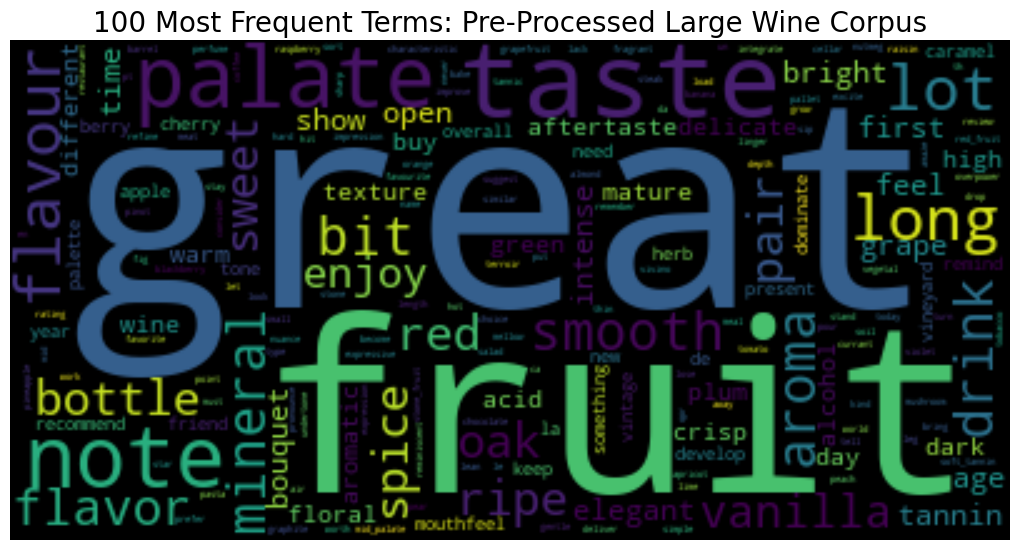

In [36]:
wordcloud = WordCloud(stopwords=set(STOPWORDS),
                      background_color='black'
                     ).generate(" ".join(sorted_wc.term.values.tolist()))
plt.imshow(wordcloud,interpolation = 'bilinear')
fig=plt.gcf()
fig.set_size_inches(10,12)
plt.axis('off')
plt.title(f"100 Most Frequent Terms: Pre-Processed Large Wine Corpus",fontsize=20)
plt.tight_layout(pad=0)
plt.show()

In [28]:
vocab = sorted_wc['term'].values.tolist()
distinct_question_vocab = list(set(" ".join(questions_df.question.values.tolist()).split(" "))) 
distinct_question_vocab = [word.lower() for word in distinct_question_vocab]

vocab = [word.lower() for word in vocab]
vocab = list(set(vocab + distinct_question_vocab))

In [29]:
print('new length of vocab : ', len(vocab))

new length of vocab :  199964


In [30]:
vectorizer = CountVectorizer(ngram_range=(1, 1), 
                             stop_words=more_stop_words,
                             vocabulary=vocab
                            )

In [31]:
text_for_counts = df2.processed_text_str.values.tolist()
matrix = vectorizer.fit_transform(text_for_counts)
words = vectorizer.get_feature_names_out()
doc_term_df = pd.DataFrame(matrix.toarray(), columns=words, index=df2.index)

In [32]:
doc_term_df.shape

(93, 199964)

In [33]:
topN_bow = pd.DataFrame(doc_term_df.mean().sort_values(ascending=False).head(25))
topN_bow.rename(columns={0: 'Mean BOW'}, inplace=True)
topN_bow.head(25)

,Mean BOW
palate,368.526882
note,349.032258
dry,335.354839
nice,299.838710
great,279.053763
acidity,259.505376
balance,238.365591
smooth,221.784946
tannin,221.774194
vanilla,214.473118


In [34]:
asctime()

'Sun Apr 30 17:45:35 2023'

In [35]:
doc_term_df.shape

(93, 199964)

# Test Performance

In [36]:
asctime()

'Sun Apr 30 17:45:35 2023'

In [37]:
questions_df.head()

,question,processed_question_str,processed_question_tokens
0,I want to split a bottle of wine with my frien...,want split bottle friend birthday likely eat s...,"[want, split, bottle, friend, birthday, likely..."
1,Tonight I will be eating pasta at the Italian ...,tonight eat pasta italian_restaurant dinner nt...,"[tonight, eat, pasta, italian, restaurant, din..."
2,I like Cabernets from Napa Valley,like cabernet napa_valley,"[like, cabernet, napa, valley]"
3,I'm looking to try something different for my ...,look try_something_different dinner tonight wh...,"[look, try, something, different, dinner, toni..."
4,I don't know what I want.,nt know want,"[nt, know, want]"


In [38]:
question_vectorizer = CountVectorizer(ngram_range=(1, 1), 
                             stop_words=more_stop_words,
                             vocabulary=vocab)

question = questions_df.loc[0, 'question']
question_tokens = questions_df.loc[0, 'processed_question_tokens']
transformed_question = question_vectorizer.fit_transform(question_tokens)

transformed_question_as_array = transformed_question.toarray()
question_term_matrix = transformed_question.todense()

question_term_df = pd.DataFrame(question_term_matrix, 
                           columns=question_vectorizer.get_feature_names_out())

print(question_term_df.shape)

(10, 199964)


In [39]:
doc_term_df.head() 

,vigna,superbfortunate,iwi,standexactly,gruntier,wayvaltellina,barolored,barbarossa,extrahalf_star,tobtaste,...,lushwow,gretzky,makuhari,red_coloured,faustinos,gestoomde,johann,mealabsolute,transpose,forwardspain
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,34,0,0,0,0,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,28,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
inner_doc_term_df = doc_term_df[list(question_term_df.columns)] 

In [41]:
inner_doc_term_df.head()

,vigna,superbfortunate,iwi,standexactly,gruntier,wayvaltellina,barolored,barbarossa,extrahalf_star,tobtaste,...,lushwow,gretzky,makuhari,red_coloured,faustinos,gestoomde,johann,mealabsolute,transpose,forwardspain
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,34,0,0,0,0,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,28,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
knn = NearestNeighbors(metric='cosine', 
                       algorithm='brute', 
                       n_neighbors=5, 
                       n_jobs=3)

knn.fit(inner_doc_term_df)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=3)

In [43]:
distances, indices = knn.kneighbors(question_term_df)
recs = pd.DataFrame()

In [44]:
df2.reset_index(drop=True, inplace=True)

In [45]:
for INDEX in range(len(indices)):
    df_distances = pd.DataFrame(distances[INDEX], columns=['cosine_distance_score'], index=indices[INDEX])
    df_wines = df2.iloc[indices[INDEX]]
    new_recs = df_distances.merge(df_wines, how='inner', left_index=True, right_index=True)
    recs = pd.concat([recs, new_recs])

In [46]:
df2.iloc[indices[INDEX]]

,processed_text_str,label,processed_text_tokens
91,well_round delicate flavour note strawberry_ra...,Canada Pinot Noir,"[well_round, delicate, flavour, note, strawber..."
85,oak blackcurrant_blackberry cedar plum black_f...,South Africa Cabernet Sauvignon,"[oak, blackcurrant_blackberry, cedar, plum, bl..."
90,belissimo sauvignon_blanc mineralidade_cortant...,Argentina Sauvignon Blanc,"[belissimo, sauvignon_blanc, mineralidade_cort..."
41,2020 pinot_grigio pale_lemon_colour medium_int...,Italy Trebbiano,"[2020, pinot_grigio, pale_lemon_colour, medium..."
87,fruity full aromatic bit_sharp long last taste...,Portugal Aragonez,"[fruity, full, aromatic, bit_sharp, long, last..."


In [47]:
question

'I want to split a bottle of wine with my friends for a birthday. Were all most likely eating something different for dinner.'

In [48]:
recommendations = {}
recommendations[question] = recs

q1_recs = recommendations[questions[0]].sort_values("cosine_distance_score", ascending=False)

In [49]:
q1_recs[['cosine_distance_score', 'label']].head()

,cosine_distance_score,label
4,0.999175,France Chardonnay
12,0.999072,United States Cabernet Sauvignon
0,0.999012,France Chenin Blanc
34,0.998916,Italy Arneis
15,0.998771,France Sauvignon Blanc


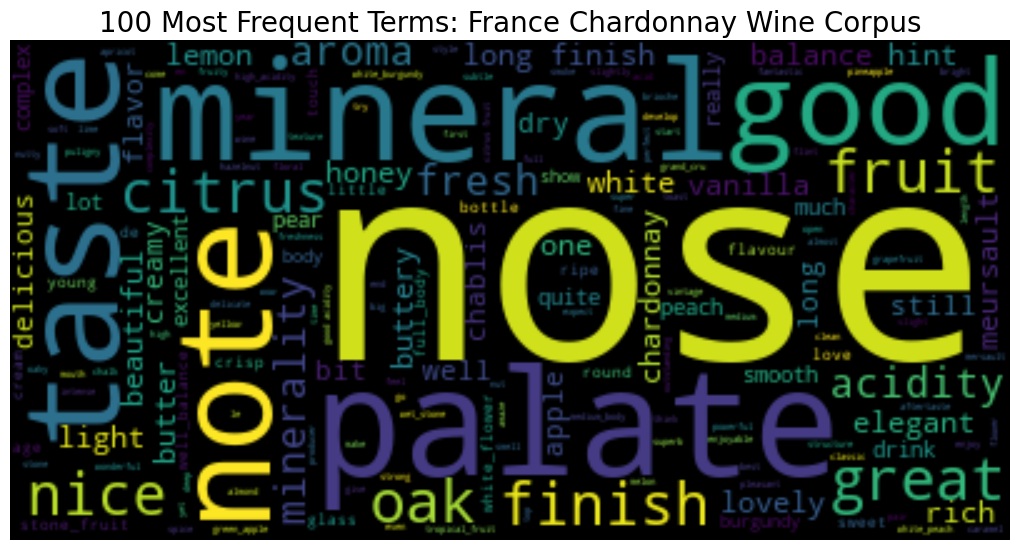

In [59]:
wordcloud = WordCloud(stopwords=list(set(STOPWORDS))+['syrah'],
                      background_color='black'
                     ).generate(" ".join(df[df.Label=='France Chardonnay'].processed_text_str.values.tolist()))
plt.imshow(wordcloud,interpolation = 'bilinear')
fig=plt.gcf()
fig.set_size_inches(10,12)
plt.axis('off')
plt.title(f"100 Most Frequent Terms: France Chardonnay Wine Corpus",fontsize=20)
plt.tight_layout(pad=0)
plt.show()

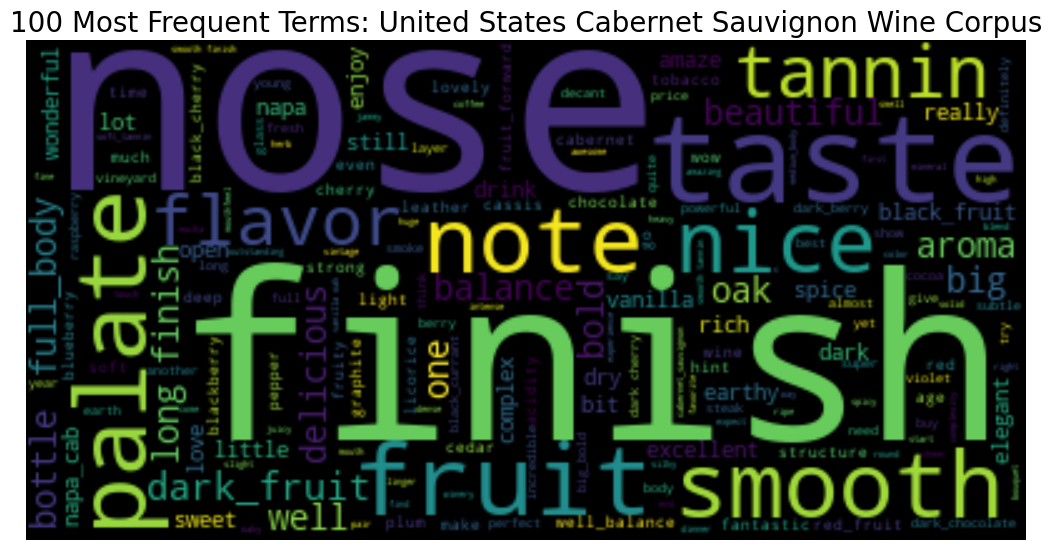

In [60]:
wordcloud = WordCloud(stopwords=list(set(STOPWORDS))+['good', 'great', 'cab'],
                      background_color='black'
                     ).generate(" ".join(df[df.Label=='United States Cabernet Sauvignon'].processed_text_str.values.tolist()))
plt.imshow(wordcloud,interpolation = 'bilinear')
fig=plt.gcf()
fig.set_size_inches(10,12)
plt.axis('off')
plt.title(f"100 Most Frequent Terms: United States Cabernet Sauvignon Wine Corpus",fontsize=20)
plt.tight_layout(pad=0)
plt.show()

In [50]:
asctime()

'Sun Apr 30 17:45:39 2023'

# XGBoost

In [62]:
# credits https://www.kaggle.com/code/diveki/classification-with-nlp-xgboost-and-pipelines

In [53]:
# creating a subset of the dataframe for faster processing times
# old world wines. of more well-known grapes.

old_world_subset = pd.concat([df[df.Country=='Italy'],
                    df[df.Country=='France'],
                    df[df.Country=='Portugal'],
                    df[df.Country=='Spain'],
                    df[df.Country=='Germany'],
                    df[df.Country=='Austria']])

old_world_subset = old_world_subset[(old_world_subset.Body_Description!='Very_light_bodied')
                               & (old_world_subset.Body_Description!='Light_bodied')
                               & (old_world_subset.Single_Most_Used_Grape!='Corvina')
                               & (old_world_subset.Single_Most_Used_Grape!='Montepulciano')
                               & (old_world_subset.Single_Most_Used_Grape!='Gouveio')
                               & (old_world_subset.Single_Most_Used_Grape!='Baga')
                               & (old_world_subset.Single_Most_Used_Grape!='Aragonez')
                               & (old_world_subset.Single_Most_Used_Grape!='Cabernet Franc')
                               & (old_world_subset.Single_Most_Used_Grape!='Touriga Nacional')
                               & (old_world_subset.Single_Most_Used_Grape!='Primitivo')]

In [54]:
old_world_subset.shape

(122677, 52)

In [55]:
old_world_subset = old_world_subset.groupby('Label').filter(lambda xyz: len(xyz) > 2000)
old_world_subset = old_world_subset.groupby('Label').sample(2000)

In [59]:
old_world_subset.shape

(30000, 52)

In [60]:
labels = {old_world_subset.Label.unique()[idx]:idx for idx in range(len(old_world_subset.Label.unique()))}
old_world_subset['Label_Cat'] = old_world_subset['Label'].apply(lambda xyz: labels[xyz])
y1 = old_world_subset['Label_Cat']

In [61]:
x1 = old_world_subset[['Price', 
                       'processed_text_str']]

In [72]:
clf = xgboost.XGBClassifier(random_state=8675309, seed=2, colsample_bytree=0.6, subsample=0.7)

In [73]:
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None, *parg, **kwarg):
        return self

    def transform(self, X):
        # returns the input as a string
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # returns the input as a dataframe
        return X[[self.key]]

In [62]:
vec_cv = CountVectorizer(ngram_range=(1,1), analyzer='word')

In [75]:
x1.head(1)

,Price,processed_text_str
244786,166.665,40 blackberry_plum nose pallette also dark_fru...


In [76]:
y1.head()

244786    0
249717    0
151200    0
107232    0
253508    0
Name: Label_Cat, dtype: int64

In [77]:
labels

{'France Cabernet Sauvignon': 0,
 'France Chardonnay': 1,
 'France Chenin Blanc': 2,
 'France Gamay': 3,
 'France Pinot Noir': 4,
 'France Sauvignon Blanc': 5,
 'France Shiraz/Syrah': 6,
 'France Viognier': 7,
 'Italy Cabernet Sauvignon': 8,
 'Italy Nebbiolo': 9,
 'Italy Pinot Grigio': 10,
 'Italy Sangiovese': 11,
 'Spain Grenache': 12,
 'Spain Shiraz/Syrah': 13,
 'Spain Tempranillo': 14}

In [74]:
text = Pipeline([
                ('selector', TextSelector(key='processed_text_str')),
                ('vectorizer', vec_cv)
                ])

In [75]:
price = Pipeline([
                ('selector', NumberSelector(key='Price')),
                ])

# these made the predictors too good lol
acidity = Pipeline([
                ('selector', NumberSelector(key='Acidity')),
                ])

intensity = Pipeline([
                ('selector', NumberSelector(key='Intensity')),
                ])

sweetness = Pipeline([
                ('selector', NumberSelector(key='Sweetness')),
                ])

tannin = Pipeline([
                ('selector', NumberSelector(key='Tannin')),
                ])

In [76]:
feats = FeatureUnion([('processed_text_str', text),
                      ('Price', price)
                      ])

In [ ]:
pipe = Pipeline([('feats', feats),
                 ('clf', clf)
                 ])

In [78]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size=0.33, random_state=8675309, stratify=y1)

In [83]:
def print_stats(preds, target, labels, sep='-', sep_len=40, fig_size=(12, 10)):
    print('Accuracy = %.2f' % metrics.accuracy_score(target, preds))
    print(sep*sep_len)
    print('Classification report:')
    print(metrics.classification_report(target, preds))
    print(sep*sep_len)
    print('Confusion matrix')
    cm = metrics.confusion_matrix(target, preds)
    cm = cm / np.sum(cm, axis=1)[:,None]
    sns.set(rc={'figure.figsize':fig_size})
    sns.heatmap(cm, 
                xticklabels=labels,
                yticklabels=labels,
                annot=True, 
                cmap = 'YlGnBu')
    plt.tight_layout()
    plt.pause(0.05)

In [84]:
asctime()

'Sun Apr 30 14:15:02 2023'

In [87]:
param_grid = {
     'clf__n_estimators': [1000] 
}

# grid search cross validation instantiation
grid_search = GridSearchCV(estimator = pipe,
                           param_grid = param_grid, 
                           cv = 2, 
                           n_jobs = 3, 
                           verbose = 1, 
                           return_train_score=True)

#hyperparameter fitting
grid_search.fit(X_train1, y_train1)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('feats',
                                        FeatureUnion(transformer_list=[('processed_text_str',
                                                                        Pipeline(steps=[('selector',
                                                                                         TextSelector(key='processed_text_str')),
                                                                                        ('vectorizer',
                                                                                         CountVectorizer())])),
                                                                       ('Price',
                                                                        Pipeline(steps=[('selector',
                                                                                         NumberSelector(key='Price'))]))])),
                                       ('clf',
                                      

In [88]:
grid_search.cv_results_['mean_train_score']
grid_search.cv_results_['mean_test_score']

array([0.58298507])

In [89]:
grid_search.best_params_

{'clf__n_estimators': 1000}

In [90]:
clf_test = grid_search.best_estimator_

In [91]:
model = clf_test.fit(X_train1, y_train1) # 3:19

In [92]:
preds = clf_test.predict(X_test1)

In [93]:
clf_test.classes_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [94]:
labels

{'France Cabernet Sauvignon': 0,
 'France Chardonnay': 1,
 'France Chenin Blanc': 2,
 'France Gamay': 3,
 'France Pinot Noir': 4,
 'France Sauvignon Blanc': 5,
 'France Shiraz/Syrah': 6,
 'France Viognier': 7,
 'Italy Cabernet Sauvignon': 8,
 'Italy Nebbiolo': 9,
 'Italy Pinot Grigio': 10,
 'Italy Sangiovese': 11,
 'Spain Grenache': 12,
 'Spain Shiraz/Syrah': 13,
 'Spain Tempranillo': 14}

In [95]:
pd.options.display.float_format = "{:,.2f}".format

Accuracy = 0.64
----------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       712
           1       0.73      0.70      0.72       689
           2       0.63      0.60      0.62       694
           3       0.66      0.60      0.63       731
           4       0.74      0.69      0.71       712
           5       0.60      0.66      0.63       597
           6       0.45      0.51      0.48       587
           7       0.57      0.62      0.59       608
           8       0.76      0.72      0.74       700
           9       0.63      0.63      0.63       659
          10       0.68      0.66      0.67       687
          11       0.50      0.62      0.55       533
          12       0.64      0.59      0.61       712
          13       0.69      0.69      0.69       666
          14       0.52      0.56      0.54       613

    accuracy                           0.64      9900


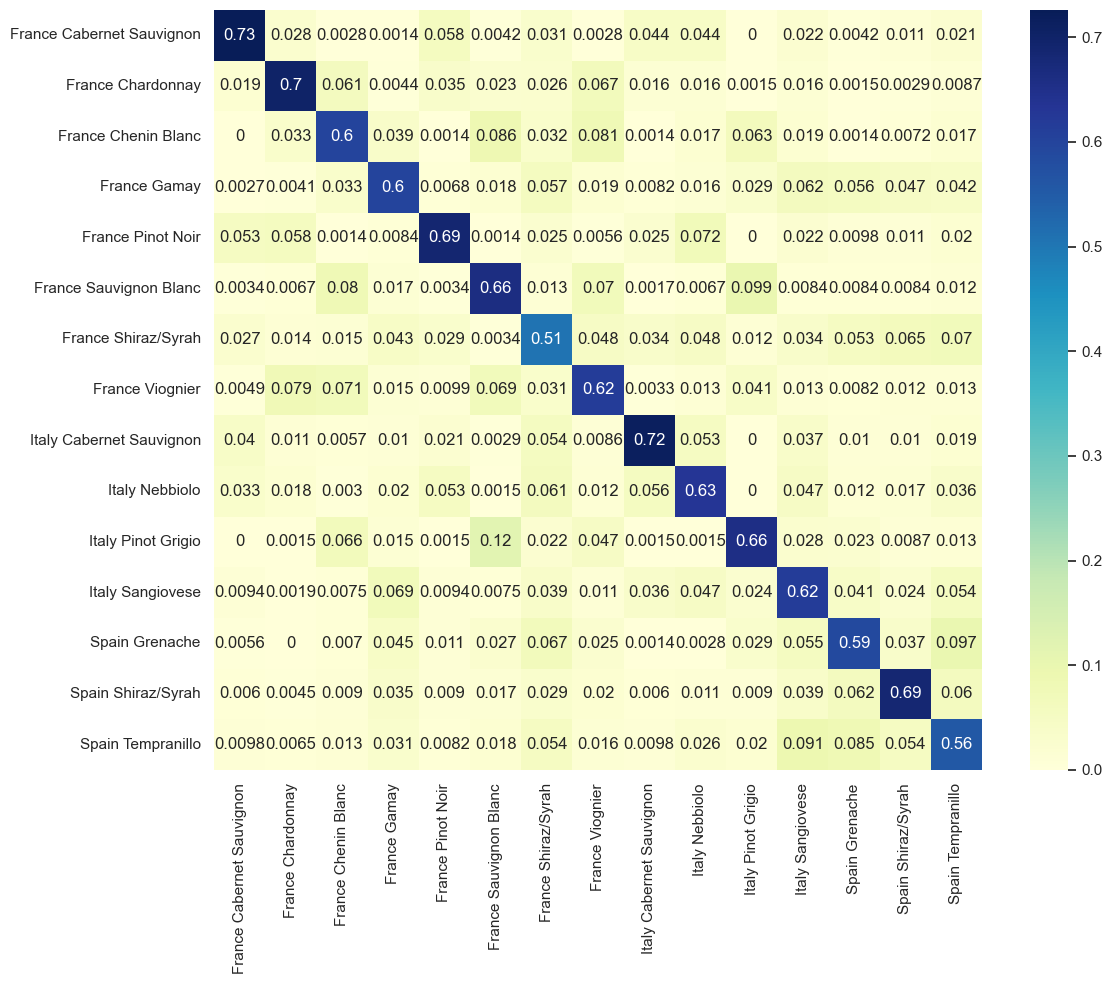

In [96]:
print_stats(y_test1, preds, labels.keys())

In [97]:
asctime()

'Sun Apr 30 16:17:08 2023'

# KNN Classifier

In [64]:
x2 = old_world_subset[['processed_text_str']]
X_train2, X_test2, y_train2, y_test2 = train_test_split(x2, y1, test_size=0.33, random_state=8675309, stratify=y1)

In [65]:
knn_classifier = KNeighborsClassifier(metric = 'cosine', 
                       algorithm = 'brute',
                       n_neighbors = 20, 
                       n_jobs = 2)

In [79]:
feats2 = FeatureUnion([('processed_text_str', text)
                      ])

In [80]:
knn_class_pipe = Pipeline([('feats', feats2),
                 ('clf', knn_classifier)
                 ])

In [81]:
knn_class_pipe.fit(X_train2, y_train2)

Pipeline(steps=[('feats',
                 FeatureUnion(transformer_list=[('processed_text_str',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='processed_text_str')),
                                                                 ('vectorizer',
                                                                  CountVectorizer())]))])),
                ('clf',
                 KNeighborsClassifier(algorithm='brute', metric='cosine',
                                      n_jobs=2, n_neighbors=20))])

In [82]:
y_pred2 = knn_class_pipe.predict(X_test2) # Predicting

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.


In [83]:
print(metrics.accuracy_score(y_test2, y_pred2)) 

0.24525252525252525


In [84]:
asctime()

'Sun Apr 30 17:47:30 2023'

# KNN Classifier Explainability

#### LIME

In [106]:
asctime()

'Sun Apr 30 16:17:33 2023'

In [107]:
lime_explainer = LimeTextExplainer(class_names = list(labels.keys()), 
                                   bow=True, 
                                   verbose=True)

In [117]:
instance = X_test2.iloc[randint(0,len(X_test2)-1)][0]
print(instance)

# c = make_pipeline(vec_cv, knn_classifier) # also works
c = make_pipeline(vec_cv, #CountVectorizer(ngram_range=(1,1), analyzer='word')
                  knn_class_pipe['clf']) 

please_explain = lime_explainer.explain_instance(instance, 
                                                 c.predict_proba, 
                                                 num_features=20)
please_explain.show_in_notebook()

apricot lovely texture lot usual blush rise good mouth_feel
Intercept 0.03524434660092718
Prediction_local [0.13479282]
Right: 0.15


In [119]:
df[df.processed_text_str=='apricot lovely texture lot usual blush rise good mouth_feel'].Label

217936    France Shiraz/Syrah
Name: Label, dtype: object

In [110]:
asctime()

'Sun Apr 30 16:17:45 2023'

# Recommendations Using Raw Cosine Similarity

In [85]:
asctime()

'Sun Apr 30 17:47:32 2023'

In [86]:
vectorizer = CountVectorizer(ngram_range=(1, 1), 
                             stop_words=more_stop_words,
                             vocabulary=vocab)

In [87]:
processed_question1 = questions_df.loc[0, 'processed_question_str']
processed_question2 = questions_df.loc[1, 'processed_question_str']
processed_question3 = questions_df.loc[2, 'processed_question_str']
processed_question4 = questions_df.loc[3, 'processed_question_str']
processed_question5 = questions_df.loc[4, 'processed_question_str']
processed_question6 = questions_df.loc[5, 'processed_question_str']
processed_question7 = questions_df.loc[6, 'processed_question_str']
processed_question8 = questions_df.loc[7, 'processed_question_str']
processed_question9 = questions_df.loc[8, 'processed_question_str']
processed_question10 = questions_df.loc[9, 'processed_question_str']
processed_question11 = questions_df.loc[10, 'processed_question_str']
processed_question12 = questions_df.loc[11, 'processed_question_str']

In [88]:
def cosine_similarity_countvectorizer_method(s1, s2):
    
    # sentences to list
    allsentences = [s1 , s2]
 
    # text to vector
    all_sentences_to_vector = vectorizer.fit_transform(allsentences)
    text_to_vector_v1 = all_sentences_to_vector.toarray()[0].reshape(1,-1)
    text_to_vector_v2 = all_sentences_to_vector.toarray()[1].reshape(1,-1)
    
    # distance of similarity
    cosine = cosine_similarity(text_to_vector_v1, text_to_vector_v2)
    return cosine 

In [89]:
cosine_similarity_countvectorizer_method('i like wine', 'this wine was green and peppery')

array([[0.31622777]])

In [90]:
cosine_similarity_countvectorizer_method('michaealangelo is a ninja turtle', 'this wine was green and peppery')

array([[0.]])

In [91]:
def cos_sim_cv_q1(s1):
    cosine = cosine_similarity_countvectorizer_method(s1=s1, s2=processed_question1)
    return cosine[0][0]

def cos_sim_cv_q2(s1):
    cosine = cosine_similarity_countvectorizer_method(s1=s1, s2=processed_question2)
    return cosine[0][0]
    
def cos_sim_cv_q3(s1):
    cosine = cosine_similarity_countvectorizer_method(s1=s1, s2=processed_question3)
    return cosine[0][0]
    
def cos_sim_cv_q4(s1):
    cosine = cosine_similarity_countvectorizer_method(s1=s1, s2=processed_question4)
    return cosine[0][0]

def cos_sim_cv_q5(s1):
    cosine = cosine_similarity_countvectorizer_method(s1=s1, s2=processed_question5)
    return cosine[0][0]

def cos_sim_cv_q6(s1):
    cosine = cosine_similarity_countvectorizer_method(s1=s1, s2=processed_question6)
    return cosine[0][0]

def cos_sim_cv_q7(s1):
    cosine = cosine_similarity_countvectorizer_method(s1=s1, s2=processed_question7)
    return cosine[0][0]

def cos_sim_cv_q8(s1):
    cosine = cosine_similarity_countvectorizer_method(s1=s1, s2=processed_question8)
    return cosine[0][0]

def cos_sim_cv_q9(s1):
    cosine = cosine_similarity_countvectorizer_method(s1=s1, s2=processed_question9)
    return cosine[0][0]

def cos_sim_cv_q10(s1):
    cosine = cosine_similarity_countvectorizer_method(s1=s1, s2=processed_question10)
    return cosine[0][0]

def cos_sim_cv_q11(s1):
    cosine = cosine_similarity_countvectorizer_method(s1=s1, s2=processed_question11)
    return cosine[0][0]

def cos_sim_cv_q12(s1):
    cosine = cosine_similarity_countvectorizer_method(s1=s1, s2=processed_question12)
    return cosine[0][0]


## Question 1

In [92]:
questions_df.loc[0, 'question']

'I want to split a bottle of wine with my friends for a birthday. Were all most likely eating something different for dinner.'

In [93]:
df2['q1_cosine_similarity_bow'] = df2.processed_text_str.parallel_apply(cos_sim_cv_q1)

In [94]:
df2.sort_values('q1_cosine_similarity_bow', ascending=False).head(5)[['q1_cosine_similarity_bow', 'label']]

,q1_cosine_similarity_bow,label
74,0.065813,Canada Shiraz/Syrah
12,0.050772,United States Cabernet Sauvignon
89,0.046779,Australia Cabernet Sauvignon
63,0.044651,Italy Montepulciano
21,0.040106,Italy Corvina


## Question 2

In [95]:
questions_df.loc[1, 'question']

"Tonight I will be eating pasta at the Italian restaurant for dinner. I don't like sweet wines."

In [96]:
df2['q2_cosine_similarity_bow'] = df2.processed_text_str.parallel_apply(cos_sim_cv_q2)

In [97]:
df2.sort_values('q2_cosine_similarity_bow', ascending=False).head(5)[['q2_cosine_similarity_bow', 'label']]

,q2_cosine_similarity_bow,label
42,0.218912,United States Riesling
13,0.193720,Portugal Touriga Nacional
75,0.187066,Australia Pinot Gris
36,0.181647,Portugal Gouveio
38,0.160540,United States Pinot Gris


## Question 3

In [98]:
questions_df.loc[2, 'question']

'I like Cabernets from Napa Valley'

In [100]:
df2['q3_cosine_similarity_bow'] = df2.processed_text_str.parallel_apply(cos_sim_cv_q3)

In [101]:
df2.sort_values('q3_cosine_similarity_bow', ascending=False).head(5)[['q3_cosine_similarity_bow', 'label']]

,q3_cosine_similarity_bow,label
92,0.137493,France Grenache Blanc
75,0.125135,Australia Pinot Gris
72,0.109984,Italy Gewürztraminer
26,0.102686,United States Sauvignon Blanc
38,0.102472,United States Pinot Gris


## Question 4

In [102]:
questions_df.loc[3, 'question']

"I'm looking to try something different for my dinner tonight. I'm having a white fish and tend to go for acidic white wines."

In [103]:
df2['q4_cosine_similarity_bow'] = df2.processed_text_str.parallel_apply(cos_sim_cv_q4)

In [104]:
df2.sort_values('q4_cosine_similarity_bow', ascending=False).head(5)[['q4_cosine_similarity_bow', 'label']]

,q4_cosine_similarity_bow,label
88,0.079982,Australia Sauvignon Blanc
91,0.077596,Canada Pinot Noir
71,0.076781,Italy Malvasia
18,0.068622,France Melon de Bourgogne
33,0.066029,New Zealand Sauvignon Blanc


## Question 5

In [105]:
questions_df.loc[4, 'question']

"I don't know what I want."

In [106]:
df2['q5_cosine_similarity_bow'] = df2.processed_text_str.parallel_apply(cos_sim_cv_q5)

In [107]:
df2.sort_values('q5_cosine_similarity_bow', ascending=False).head(5)[['q5_cosine_similarity_bow', 'label']]

,q5_cosine_similarity_bow,label
57,0.057414,Argentina Pinot Gris
75,0.051526,Australia Pinot Gris
85,0.050016,South Africa Cabernet Sauvignon
77,0.049548,Australia Grenache
79,0.048938,New Zealand Shiraz/Syrah


## Question 6

In [108]:
questions_df.loc[5, 'question']

'Do you have a red wine that is light? Not too heavy.'

In [109]:
df2['q6_cosine_similarity_bow'] = df2.processed_text_str.parallel_apply(cos_sim_cv_q6)

In [110]:
df2.sort_values('q6_cosine_similarity_bow', ascending=False).head(5)[['q6_cosine_similarity_bow', 'label']]

,q6_cosine_similarity_bow,label
49,0.329932,Italy Pinot Noir
5,0.288419,France Gamay
54,0.283313,Germany Pinot Noir
69,0.269745,France Cabernet Franc
22,0.263923,New Zealand Pinot Noir


## Question 7

In [111]:
questions_df.loc[6, 'question']

'Do you have any heavy flavorful red wines?'

In [112]:
df2['q7_cosine_similarity_bow'] = df2.processed_text_str.parallel_apply(cos_sim_cv_q7)

In [113]:
df2.sort_values('q7_cosine_similarity_bow', ascending=False).head(5)[['q7_cosine_similarity_bow', 'label']]

,q7_cosine_similarity_bow,label
78,0.184909,Portugal Baga
69,0.163524,France Cabernet Franc
32,0.156706,Spain Grenache
14,0.155518,Spain Shiraz/Syrah
70,0.150237,Argentina Tempranillo


## Question 8

In [114]:
questions_df.loc[7, 'question']

"I am looking for a dry white wine that's easy to drink."

In [115]:
df2['q8_cosine_similarity_bow'] = df2.processed_text_str.parallel_apply(cos_sim_cv_q8)

In [116]:
df2.sort_values('q8_cosine_similarity_bow', ascending=False).head(5)[['q8_cosine_similarity_bow', 'label']]

,q8_cosine_similarity_bow,label
58,0.280630,Portugal Malvasia
57,0.248612,Argentina Pinot Gris
36,0.247461,Portugal Gouveio
18,0.245697,France Melon de Bourgogne
10,0.245666,Italy Pinot Grigio


## Question 9

In [117]:
questions_df.loc[8, 'question']

'Wine is for snobs'

In [118]:
df2['q9_cosine_similarity_bow'] = df2.processed_text_str.parallel_apply(cos_sim_cv_q9)

In [119]:
df2.sort_values('q9_cosine_similarity_bow', ascending=False).head(5)[['q9_cosine_similarity_bow', 'label']]

,q9_cosine_similarity_bow,label
82,0.011501,France Grenache
39,0.005935,Spain Sauvignon Blanc
20,0.000936,Portugal Arinto de Bucelas
14,0.000625,Spain Shiraz/Syrah
46,0.000480,United States Shiraz/Syrah


## Question 10

In [120]:
questions_df.loc[9, 'question']

'I am not normally a wine drinker. What do you recommend?'

In [121]:
df2['q10_cosine_similarity_bow'] = df2.processed_text_str.parallel_apply(cos_sim_cv_q10)

In [122]:
df2.sort_values('q10_cosine_similarity_bow', ascending=False).head(5)[['q10_cosine_similarity_bow', 'label']]

,q10_cosine_similarity_bow,label
53,0.037832,Argentina Petit Verdot
85,0.025008,South Africa Cabernet Sauvignon
82,0.019920,France Grenache
92,0.019642,France Grenache Blanc
28,0.017243,Chile Cabernet Sauvignon


## Question 11

In [123]:
questions_df.loc[10, 'question']

'I want to split a bottle of red wine with my friends for a birthday. Were all most likely eating something different for dinner.'

In [124]:
df2['q11_cosine_similarity_bow'] = df2.processed_text_str.parallel_apply(cos_sim_cv_q11)

In [126]:
df2.sort_values('q11_cosine_similarity_bow', ascending=False).head(5)[['q11_cosine_similarity_bow', 'label']]

,q11_cosine_similarity_bow,label
1,0.112279,France Pinot Noir
32,0.108601,Spain Grenache
78,0.108597,Portugal Baga
44,0.108007,Italy Grenache
70,0.106049,Argentina Tempranillo


## Question 12

In [127]:
questions_df.loc[11, 'question']

'I like Cabernet Sauvignon s from Napa Valley'

In [128]:
df2['q12_cosine_similarity_bow'] = df2.processed_text_str.parallel_apply(cos_sim_cv_q12)

In [130]:
df2.sort_values('q12_cosine_similarity_bow', ascending=False).head(5)[['q12_cosine_similarity_bow', 'label']]

,q12_cosine_similarity_bow,label
92,0.168394,France Grenache Blanc
75,0.153259,Australia Pinot Gris
72,0.134703,Italy Gewürztraminer
38,0.125502,United States Pinot Gris
26,0.123234,United States Sauvignon Blanc


In [131]:
asctime()

'Sun Apr 30 18:22:45 2023'

# Gather (Country, Grape) Recommendations Per Question

In [132]:
asctime()

'Sun Apr 30 18:22:45 2023'

In [133]:
interesting_columns = ['cosine_distance_score', 'label']
recommendations = {}
similarity_list = []
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5, n_jobs=3) # n_jobs -1
question_vectorizer = vectorizer

In [134]:
question = questions_df.loc[0, 'question']
question_tokens = questions_df.loc[0, 'processed_question_tokens']
transformed_question = question_vectorizer.fit_transform(question_tokens)

transformed_question_as_array = transformed_question.toarray()
question_term_matrix = transformed_question.todense()

question_term_df = pd.DataFrame(question_term_matrix, 
                           columns=question_vectorizer.get_feature_names_out())

print(question_term_df.shape)

(10, 199964)


In [135]:
knn.fit(doc_term_df)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=3)

In [136]:
doc_term_df.shape

(93, 199964)

In [137]:
for idx, question in enumerate(questions):
    print(questions_df.question.iloc[idx])
    question_tokens = questions_df.loc[idx, 'processed_question_tokens']
    transformed_question = question_vectorizer.fit_transform(question_tokens)
    
    # bc sparse; reduces dimensionality
    transformed_question_as_array = transformed_question.toarray()
    question_term_matrix = transformed_question.todense()
    question_term_df = pd.DataFrame(question_term_matrix, 
                               columns=question_vectorizer.get_feature_names_out())
    
    #https://scikit-learn.org/stable/modules/neighbors.html
#    knn.fit(doc_term_df[list(question_term_df.columns)])
    distances, indices = knn.kneighbors(question_term_df)
    
    recs = pd.DataFrame()
    for INDEX in range(len(indices)): # number of iterations as length of question
        df_distances = pd.DataFrame(distances[INDEX], columns=['cosine_distance_score'], index=indices[INDEX])
        df_wines = df2.iloc[indices[INDEX]] # df_wines = df2.iloc[indices[INDEX]]
        new_recs = df_distances.merge(df_wines, how='inner', left_index=True, right_index=True) # shape of 5 neighbs
        recs = pd.concat([recs, new_recs]) # size of question length * 5
    recommendations[question] = recs

I want to split a bottle of wine with my friends for a birthday. Were all most likely eating something different for dinner.
Tonight I will be eating pasta at the Italian restaurant for dinner. I don't like sweet wines.
I like Cabernets from Napa Valley
I'm looking to try something different for my dinner tonight. I'm having a white fish and tend to go for acidic white wines.
I don't know what I want.
Do you have a red wine that is light? Not too heavy.
Do you have any heavy flavorful red wines?
I am looking for a dry white wine that's easy to drink.
Wine is for snobs
I am not normally a wine drinker. What do you recommend?
I want to split a bottle of red wine with my friends for a birthday. Were all most likely eating something different for dinner.
I like Cabernet Sauvignon s from Napa Valley


In [138]:
recommendations[question].sort_values('cosine_distance_score', ascending=True).head(20)

,cosine_distance_score,processed_text_str,label,processed_text_tokens,q1_cosine_similarity_bow,q2_cosine_similarity_bow,q3_cosine_similarity_bow,q4_cosine_similarity_bow,q5_cosine_similarity_bow,q6_cosine_similarity_bow,q7_cosine_similarity_bow,q8_cosine_similarity_bow,q9_cosine_similarity_bow,q10_cosine_similarity_bow,q11_cosine_similarity_bow,q12_cosine_similarity_bow
92,0.761855,refresh good variety cheese sharp light togeth...,France Grenache Blanc,"[refresh, good, variety, cheese, sharp, light,...",0.012028,0.120281,0.137493,0.024056,0.000000,0.078567,0.051031,0.102062,0.000000,0.019642,0.022680,0.168394
75,0.783259,noosa head do river cruise morning like house ...,Australia Pinot Gris,"[noosa, head, do, river, cruise, morning, like...",0.018030,0.187066,0.125135,0.054091,0.051526,0.209786,0.035061,0.226303,0.000000,0.014722,0.025499,0.153259
72,0.809502,43 hate kind wine nasties month year make long...,Italy Gewürztraminer,"[43, hate, kind, wine, nasties, month, year, m...",0.014432,0.120270,0.109984,0.014432,0.023568,0.015712,0.013607,0.095249,0.000000,0.007856,0.013607,0.134703
38,0.824752,2021 pinot_gris pale_lemon_green_medium pronou...,United States Pinot Gris,"[2021, pinot_gris, pale_lemon_green_medium, pr...",0.027516,0.160540,0.102472,0.062553,0.034588,0.175528,0.036673,0.211921,0.000000,0.012930,0.034714,0.125502
42,0.837804,2018 riesling medium dark gold_colour low inte...,United States Riesling,"[2018, riesling, medium, dark, gold_colour, lo...",0.023666,0.218912,0.094759,0.049608,0.037532,0.108508,0.036044,0.228491,0.000000,0.008918,0.030894,0.116055
34,0.858014,international sb day version best sauvignon wo...,Italy Arneis,"[international, sb, day, version, best, sauvig...",0.026824,0.091969,0.066332,0.036788,0.026282,0.081976,0.031974,0.190218,0.000000,0.012515,0.032516,0.081239
89,0.905492,bold powerful dry acidic maybe well pair_foodv...,Australia Cabernet Sauvignon,"[bold, powerful, dry, acidic, maybe, well, pai...",0.046779,0.040096,0.087303,0.053462,0.043651,0.087303,0.056705,0.085057,0.000000,0.000000,0.075606,0.040096
39,0.910973,2020 sauvignon_blanc pale_gold medium pronounc...,Spain Sauvignon Blanc,"[2020, sauvignon_blanc, pale_gold, medium, pro...",0.016787,0.077641,0.065107,0.046165,0.013707,0.085667,0.011870,0.181022,0.005935,0.000000,0.015827,0.079739
12,0.929023,44 outstanding_quality california cs 100_caber...,United States Cabernet Sauvignon,"[44, outstanding_quality, california, cs, 100_...",0.050772,0.093118,0.097860,0.036984,0.034546,0.103458,0.087380,0.083872,0.000206,0.009828,0.078783,0.080388
83,0.939853,pineapple nose invite yellow_colour good grip ...,South Africa Sauvignon Blanc,"[pineapple, nose, invite, yellow_colour, good,...",0.019629,0.063795,0.048082,0.049073,0.021370,0.090821,0.027760,0.134173,0.000000,0.002671,0.018507,0.058888


In [139]:
recommendations[question].sort_values('cosine_distance_score', ascending=False).head(5).label.unique()

array(['France Grenache', 'Chile Cabernet Sauvignon',
       'United States Chenin Blanc', 'Chile Chardonnay',
       'Chile Shiraz/Syrah'], dtype=object)

## Question 12

In [140]:
print(len(question))

44


In [141]:
print(len(indices))

5


In [142]:
recommendations[questions[-1]].shape

(25, 16)

In [143]:
questions[-1]

'I like Cabernet Sauvignon s from Napa Valley'

In [144]:
recommendations[questions[-1]][interesting_columns].drop_duplicates('label').sort_values('cosine_distance_score', ascending=False).head(20).reset_index()

,index,cosine_distance_score,label
0,82,0.988499,France Grenache
1,37,0.982650,United States Chenin Blanc
2,31,0.977191,Chile Chardonnay
3,64,0.974059,Chile Shiraz/Syrah
4,68,0.972371,Israel Cabernet Sauvignon
5,35,0.971225,Chile Sauvignon Blanc
6,51,0.969353,Chile Pinot Noir
7,73,0.967182,Germany Sauvignon Blanc
8,11,0.963106,United States Chardonnay
9,28,0.962668,Chile Cabernet Sauvignon


In [145]:
questions[-2]

'I want to split a bottle of red wine with my friends for a birthday. Were all most likely eating something different for dinner.'

In [146]:
recommendations[questions[-2]][interesting_columns].drop_duplicates('label').sort_values('cosine_distance_score', ascending=False).head(20).reset_index()

,index,cosine_distance_score,label
0,4,0.999175,France Chardonnay
1,12,0.999072,United States Cabernet Sauvignon
2,0,0.999012,France Chenin Blanc
3,34,0.998916,Italy Arneis
4,15,0.998771,France Sauvignon Blanc
5,83,0.995373,South Africa Sauvignon Blanc
6,59,0.995291,Argentina Pinot Noir
7,37,0.995043,United States Chenin Blanc
8,28,0.992534,Chile Cabernet Sauvignon
9,21,0.992345,Italy Corvina


## Question 10

In [147]:
questions[-3]

'I am not normally a wine drinker. What do you recommend?'

In [148]:
recommendations[questions[-3]][interesting_columns].drop_duplicates('label').sort_values('cosine_distance_score', ascending=False).head(20).reset_index()

,index,cosine_distance_score,label
0,61,0.993093,New Zealand Pinot Gris
1,26,0.992845,United States Sauvignon Blanc
2,65,0.991594,Australia Pinot Noir
3,71,0.991483,Italy Malvasia
4,11,0.991255,United States Chardonnay
5,78,0.991195,Portugal Baga
6,38,0.991042,United States Pinot Gris
7,82,0.988499,France Grenache
8,53,0.978157,Argentina Petit Verdot
9,88,0.977378,Australia Sauvignon Blanc


## Question 9

In [149]:
questions[-4]

'Wine is for snobs'

In [150]:
recommendations[questions[-4]][interesting_columns].drop_duplicates('label').sort_values('cosine_distance_score', ascending=False).head(20).reset_index()

,index,cosine_distance_score,label
0,46,0.999520,United States Shiraz/Syrah
1,14,0.999375,Spain Shiraz/Syrah
2,20,0.999064,Portugal Arinto de Bucelas
3,39,0.994065,Spain Sauvignon Blanc
4,82,0.988499,France Grenache


## Question 8

In [151]:
questions[-5]

"I am looking for a dry white wine that's easy to drink."

In [152]:
recommendations[questions[-5]][interesting_columns].drop_duplicates('label').sort_values('cosine_distance_score', ascending=False).head(20).reset_index()

,index,cosine_distance_score,label
0,69,0.984426,France Cabernet Franc
1,75,0.980876,Australia Pinot Gris
2,57,0.980111,Argentina Pinot Gris
3,49,0.967577,Italy Pinot Noir
4,81,0.957864,South Africa Pinot Gris
5,77,0.957090,Australia Grenache
6,84,0.956189,Spain Cabernet Sauvignon
7,79,0.952910,New Zealand Shiraz/Syrah
8,82,0.907991,France Grenache
9,24,0.902243,France Cabernet Sauvignon


## Question 7

In [153]:
questions[-6]

'Do you have any heavy flavorful red wines?'

In [154]:
recommendations[questions[-6]][interesting_columns].drop_duplicates('label').sort_values('cosine_distance_score', ascending=False).head(20).reset_index()

,index,cosine_distance_score,label
0,64,0.988882,Chile Shiraz/Syrah
1,57,0.980111,Argentina Pinot Gris
2,71,0.978709,Italy Malvasia
3,82,0.976998,France Grenache
4,11,0.958460,United States Chardonnay
5,65,0.957968,Australia Pinot Noir
6,85,0.956685,South Africa Cabernet Sauvignon
7,21,0.954765,Italy Corvina
8,69,0.953279,France Cabernet Franc
9,19,0.947919,Israel Shiraz/Syrah


## Question 6

In [5]:
questions[-7]

'Do you have a red wine that is light? Not too heavy.'

In [156]:
recommendations[questions[-7]][interesting_columns].drop_duplicates('label').sort_values('cosine_distance_score', ascending=False).head(20).reset_index()

,index,cosine_distance_score,label
0,11,0.958460,United States Chardonnay
1,65,0.957968,Australia Pinot Noir
2,85,0.956685,South Africa Cabernet Sauvignon
3,21,0.954765,Italy Corvina
4,54,0.757600,Germany Pinot Noir
5,1,0.755479,France Pinot Noir
6,32,0.751748,Spain Grenache
7,78,0.744649,Portugal Baga
8,69,0.735246,France Cabernet Franc
9,81,0.726118,South Africa Pinot Gris


## Question 5

In [157]:
questions[-8]

"I don't know what I want."

In [158]:
recommendations[questions[-8]][interesting_columns].drop_duplicates('label').sort_values('cosine_distance_score', ascending=False).head(20).reset_index()

,index,cosine_distance_score,label
0,89,0.981098,Australia Cabernet Sauvignon
1,81,0.978932,South Africa Pinot Gris
2,74,0.976732,Canada Shiraz/Syrah
3,86,0.971358,New Zealand Riesling
4,60,0.968896,Australia Riesling
5,69,0.961066,France Cabernet Franc
6,77,0.957090,Australia Grenache
7,70,0.946975,Argentina Tempranillo
8,79,0.943492,New Zealand Shiraz/Syrah
9,57,0.930389,Argentina Pinot Gris


## Question 4

In [159]:
questions[-9]

"I'm looking to try something different for my dinner tonight. I'm having a white fish and tend to go for acidic white wines."

In [160]:
recommendations[questions[-9]][interesting_columns].drop_duplicates('label').sort_values('cosine_distance_score', ascending=False).head(20).reset_index()

,index,cosine_distance_score,label
0,44,0.994989,Italy Grenache
1,61,0.993093,New Zealand Pinot Gris
2,60,0.989632,Australia Riesling
3,19,0.986980,Israel Shiraz/Syrah
4,69,0.984426,France Cabernet Franc
5,70,0.982325,Argentina Tempranillo
6,89,0.981098,Australia Cabernet Sauvignon
7,75,0.980876,Australia Pinot Gris
8,57,0.980111,Argentina Pinot Gris
9,82,0.976998,France Grenache


## Question 3

In [161]:
questions[2]

'I like Cabernets from Napa Valley'

In [162]:
q3_recs = recommendations[questions[2]].drop_duplicates('label').sort_values("cosine_distance_score", ascending=False)
# Recall this is asking for Cabernet, not Cabernet Sauvignon
q3_recs.head(20)[interesting_columns].reset_index()

,index,cosine_distance_score,label
0,82,0.988499,France Grenache
1,37,0.982650,United States Chenin Blanc
2,31,0.977191,Chile Chardonnay
3,64,0.974059,Chile Shiraz/Syrah
4,68,0.972371,Israel Cabernet Sauvignon
5,35,0.971225,Chile Sauvignon Blanc
6,51,0.969353,Chile Pinot Noir
7,11,0.963106,United States Chardonnay
8,28,0.962668,Chile Cabernet Sauvignon
9,12,0.944188,United States Cabernet Sauvignon


## Question 2

In [163]:
questions[1]

"Tonight I will be eating pasta at the Italian restaurant for dinner. I don't like sweet wines."

In [164]:
q2_recs = recommendations[questions[1]].drop_duplicates(["label", "cosine_distance_score"]).sort_values("cosine_distance_score", ascending=False)
q2_recs.head(20)[interesting_columns].reset_index()

,index,cosine_distance_score,label
0,83,0.990747,South Africa Sauvignon Blanc
1,79,0.990582,New Zealand Shiraz/Syrah
2,57,0.990056,Argentina Pinot Gris
3,60,0.989632,Australia Riesling
4,64,0.988882,Chile Shiraz/Syrah
5,19,0.986980,Israel Shiraz/Syrah
6,44,0.983298,Italy Grenache
7,78,0.982390,Portugal Baga
8,89,0.981098,Australia Cabernet Sauvignon
9,75,0.980876,Australia Pinot Gris


## Question 1

In [165]:
questions[0]

'I want to split a bottle of wine with my friends for a birthday. Were all most likely eating something different for dinner.'

In [166]:
q1_recs = recommendations[questions[0]].drop_duplicates(["label", "cosine_distance_score"]).sort_values("cosine_distance_score", ascending=False)
q1_recs.head(20)[interesting_columns].reset_index()

,index,cosine_distance_score,label
0,4,0.999175,France Chardonnay
1,12,0.999072,United States Cabernet Sauvignon
2,0,0.999012,France Chenin Blanc
3,34,0.998916,Italy Arneis
4,15,0.998771,France Sauvignon Blanc
5,83,0.995373,South Africa Sauvignon Blanc
6,59,0.995291,Argentina Pinot Noir
7,37,0.995043,United States Chenin Blanc
8,28,0.992534,Chile Cabernet Sauvignon
9,21,0.992345,Italy Corvina


In [167]:
asctime()

'Sun Apr 30 18:23:09 2023'